In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Create a Headless IsaacSim

You should only have to do this part once; it will load kit, or at least the headless IsaacSim version of kit, by calling
simulation_app = SimulationApp(CONFIG).This will take some time, so give it a minute and wait for it to say "Hi".


In [1]:
from isaacsim import SimulationApp

# Set the path below to your desired nucleus server
simulation_app = SimulationApp()
print("Hi")

Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

2025-12-09T02:32:13Z [56,689ms] [Error] [asyncio] Exception in callback _patch_task.<locals>.step()
handle: <Handle _patch_task.<locals>.step()>
Traceback (most recent call last):
  File "/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x7eeebf102500> is already entered
2025-12-09T02:32:14Z [56,858ms] [Error] [asyncio] Task was destroyed but it is pending!
task: <Task pending name='Task-85' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-86' coro=<Kernel.shell_main() running at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/kern


## Create a simulation context and move camera

Here we create a `SimulationContext` object which provides a high level interface to interact with the simulation


In [2]:
from isaacsim.core.api import World
from isaacsim.core.utils.prims import create_prim
from isaacsim.core.utils.viewports import set_camera_view
from isaacsim.storage.native import get_assets_root_path
from isaacsim.core.api.materials.omni_glass import OmniGlass
from isaacsim.core.prims import SingleXFormPrim
from isaacsim.core.utils.extensions import get_extension_path_from_name
from isaacsim.core.utils.semantics import add_labels

import omni
import carb
import numpy as np

simulation_world = World(stage_units_in_meters=1.0)
set_camera_view(eye=np.array([-0.9025, 2.1035, 1.0222]), target=np.array([0.6039, 0.30, 0.0950]))

# Step our simulation to ensure everything initialized
simulation_world.step()


## Creating the scene

Re-run the cell below to randomize the scene from scratch. The goal here is to make iterating on scene setup easy and not require restarts of the omniverse application.


In [3]:
# Delete everything in the stage
simulation_world.clear()
# SCENE SETUP

# Add a distant light
create_prim("/DistantLight", "DistantLight", attributes={"inputs:intensity": 500})

# Add a ground collision plane
simulation_world.scene.add_ground_plane(size=1000, z_position=-0.5, color=np.array([1, 1, 1]))

# Load a URDF
status, import_config = omni.kit.commands.execute("URDFCreateImportConfig")
import_config.merge_fixed_joints = False
import_config.convex_decomp = False
import_config.import_inertia_tensor = True
import_config.fix_base = False
import_config.distance_scale = 1.0
import_config.create_physics_scene = False  # we already have a physics scene from simulation_world

# Get path to extension data:
extension_path = get_extension_path_from_name("isaacsim.asset.importer.urdf")
# Import URDF, stage_path contains the path the path to the usd prim in the stage.
status, stage_path = omni.kit.commands.execute(
    "URDFParseAndImportFile",
    urdf_path=extension_path + "/data/urdf/robots/carter/urdf/carter.urdf",
    import_config=import_config,
)
stage = simulation_world.stage
add_labels(stage.GetPrimAtPath(stage_path), labels=["Robot"], instance_name="class")

# Load a mesh
assets_root_path = get_assets_root_path()
if assets_root_path is None:
    carb.log_error("Could not find Isaac Sim assets folder")
usd_path = assets_root_path + "/Isaac/Props/YCB/Axis_Aligned/006_mustard_bottle.usd"

prim = create_prim(prim_path="/Mesh", usd_path=usd_path, scale=np.array([10.0, 10.0, 10.0]), semantic_label="mustard")
xform_prim = SingleXFormPrim(prim.GetPath().pathString)


# Apply a glass material to mesh
material = OmniGlass(
    "/Looks/GlassMaterial", name="glass_material", ior=1.25, depth=0.001, thin_walled=False, color=np.random.rand(3)
)
xform_prim.apply_visual_material(material)

# Set mesh transform
xform_prim.set_world_pose(position=np.array([1.00, 0, 0]))


## Viewing the scene in the notebook

This next example does not change the scene (but it could if you used commands like the ones above), but it does visualize the synthetic data by accesing the underlying annotator data. Specifically, it shows a color, depth, and segmentation view of the scene, and then displays them within the notebook.


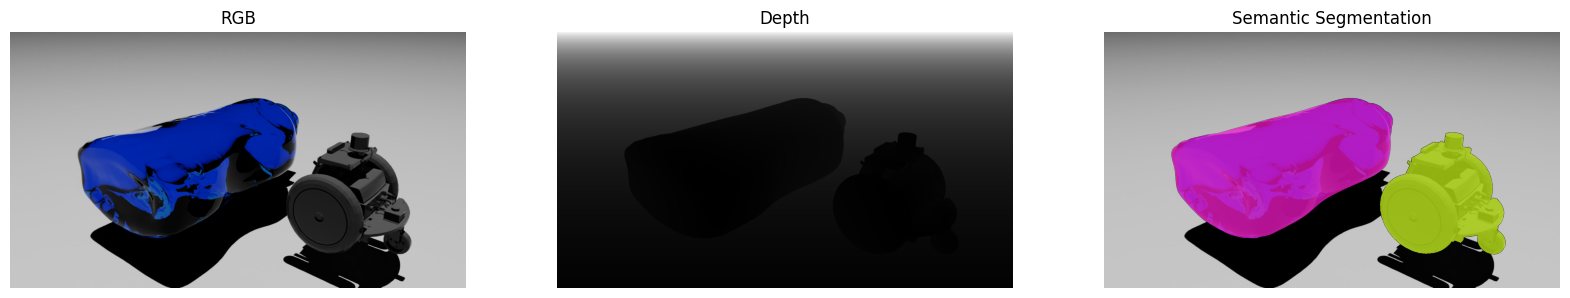

In [4]:
import matplotlib.pyplot as plt
from omni.syntheticdata import visualize
from omni.kit.viewport.utility import get_active_viewport
import omni.replicator.core as rep

viewport_api = get_active_viewport()
active_cam = viewport_api.get_active_camera()
resolution = viewport_api.get_texture_resolution()
render_product = rep.create.render_product(active_cam, resolution)

rgb = rep.AnnotatorRegistry.get_annotator("rgb")
rgb.attach([render_product])
depth = rep.AnnotatorRegistry.get_annotator("distance_to_image_plane")
depth.attach([render_product])
semantic_segmentation = rep.AnnotatorRegistry.get_annotator("semantic_segmentation")
semantic_segmentation.attach([render_product])

# Run the application for multiple frames to ensure the synthetic data pipeline is initialized
timeline = omni.timeline.get_timeline_interface()
timeline.play()
for _ in range(10):
    simulation_app.update()
timeline.pause()

# Get groundtruth
rgb_data = rgb.get_data()
depth_data = depth.get_data()
semantic_segmentation_data = semantic_segmentation.get_data()

# GROUNDTRUTH VISUALIZATION
# Setup a figure
_, axes = plt.subplots(1, 3, figsize=(20, 7))
axes = axes.flat
for ax in axes:
    ax.axis("off")

# RGB
axes[0].set_title("RGB")
axes[0].imshow(rgb_data)

# DEPTH
axes[1].set_title("Depth")
depth_data_clipped = np.clip(depth_data, 0, 255)
axes[1].imshow(visualize.colorize_distance(depth_data.squeeze()))

# SEMANTIC SEGMENTATION
axes[2].set_title("Semantic Segmentation")
# Draw the segmentation mask on top of the color image with a transparency
axes[2].imshow(rgb_data)
semantic_segmentation_rgb = visualize.colorize_segmentation(semantic_segmentation_data["data"])
axes[2].imshow(semantic_segmentation_rgb, alpha=0.7)

In [ ]:
# Cleanup application
simulation_app.close()
